In [1]:
import numpy as np
import torch
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
from pathlib import Path
import h5py

# 1) block 'blood-oxygen' 
cur = Path.cwd()
bo_root = next(p for p in [cur, *cur.parents] if p.name == "blood-oxygen")

# 2) into spo2-phonecam (subsystem of author)
spo2_root = bo_root / "spo2-phonecam"

# 3) (form the pathway of data.h5)
H5 = (spo2_root / "external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5").resolve()
print("Using:", H5)
assert H5.exists(), f"not exist：{H5}"

# 4) read
with h5py.File(H5, "r") as f:
    print("Keys:", list(f.keys()))
    data = f["dataset"][:]
    gt   = f["groundtruth"][:]
print(data.shape, gt.shape)


Using: /Users/katyhuang/Desktop/blood-oxygen/spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5
Keys: ['dataset', 'groundtruth']
(6, 6, 33660) (6, 5, 1122)


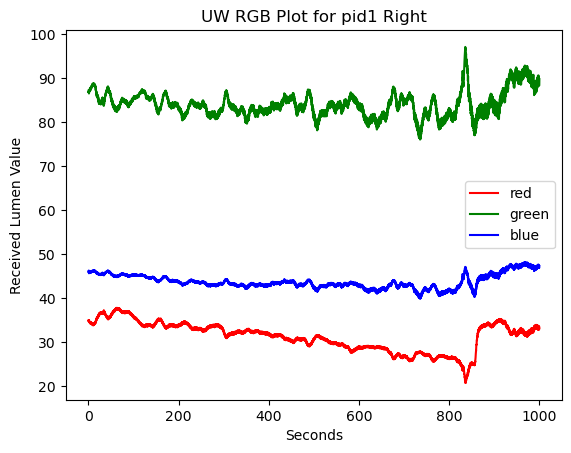

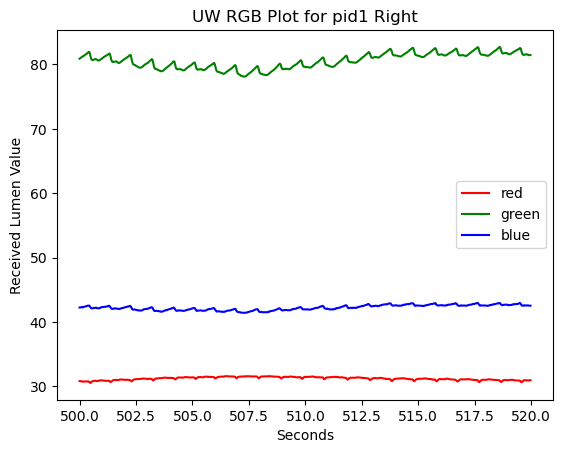

In [6]:
# Plot the red, green, and blue chanel in the time range. Choose either left or right hand.
def plot_RGB(data, pid=0, left=True, sec_from=0, sec_to=1000):
    title = "pid" + str(pid+1)
    X = np.arange(sec_from, sec_to, 1/30)
    if left:
        plt.plot(X, data[pid, 0, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 1, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 2, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Left"
    else:
        plt.plot(X, data[pid, 3, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 4, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 5, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Right"
    plt.title("UW RGB Plot for " + title)
    plt.legend()
    plt.xlabel("Seconds")
#     plt.ylim(0, 250)
    plt.ylabel("Received Lumen Value")
    plt.show()
    
plot_RGB(data, pid=0, left=False, sec_from=0, sec_to=1000)
plot_RGB(data, pid=0, left=False, sec_from=500, sec_to=520)

In [7]:
# Make a list of data points for visualizing or training
def make_temp_data(data_uw, groundtruth_uw, data_idx=[], gt_ind = 3):
    # Select 0th sample, right hand
    res_data_list = []
    res_gt_list = []
    for pid, row in enumerate(data_idx):
        if row[0] == 1:
            res_data_list.append(data_uw[pid][:3,:])
            res_gt_list.append(groundtruth_uw[pid][gt_ind,:])
        if row[1] == 1:
            res_data_list.append(data_uw[pid][3:,:]) 
            res_gt_list.append(groundtruth_uw[pid][gt_ind, :])

    results_data_list = []
    results_gt_list = []
    fps_list = []
    for i in range(len(res_gt_list)):
        # find zeros
        zeros_data = np.where(res_data_list[i][0] == 0)[0]
        zeros_gt = np.where(res_gt_list[i] == 0)[0]

        if len(zeros_data) > 0:
            result_data_i = res_data_list[i][:, :int(zeros_data[0])]
        else:
            result_data_i = res_data_list[i]
        if len(zeros_gt) > 0:
            result_gt_i = res_gt_list[i][:int(zeros_gt[0])]
        else:
            result_gt_i = res_gt_list[i]

        # Calculate shorter and clip
        fps = 30
        clip_len = min(result_gt_i.shape[0], result_data_i.shape[1] // fps)
        result_data_i = result_data_i[:, :clip_len*fps]
        result_gt_i = result_gt_i[:clip_len]

        results_gt_list.append(result_gt_i)
        results_data_list.append(result_data_i)
        fps_list.append(fps)

    return {"data": results_data_list, "gt": results_gt_list, "fps": fps_list}

UW: mean=87.220673, std=9.325543


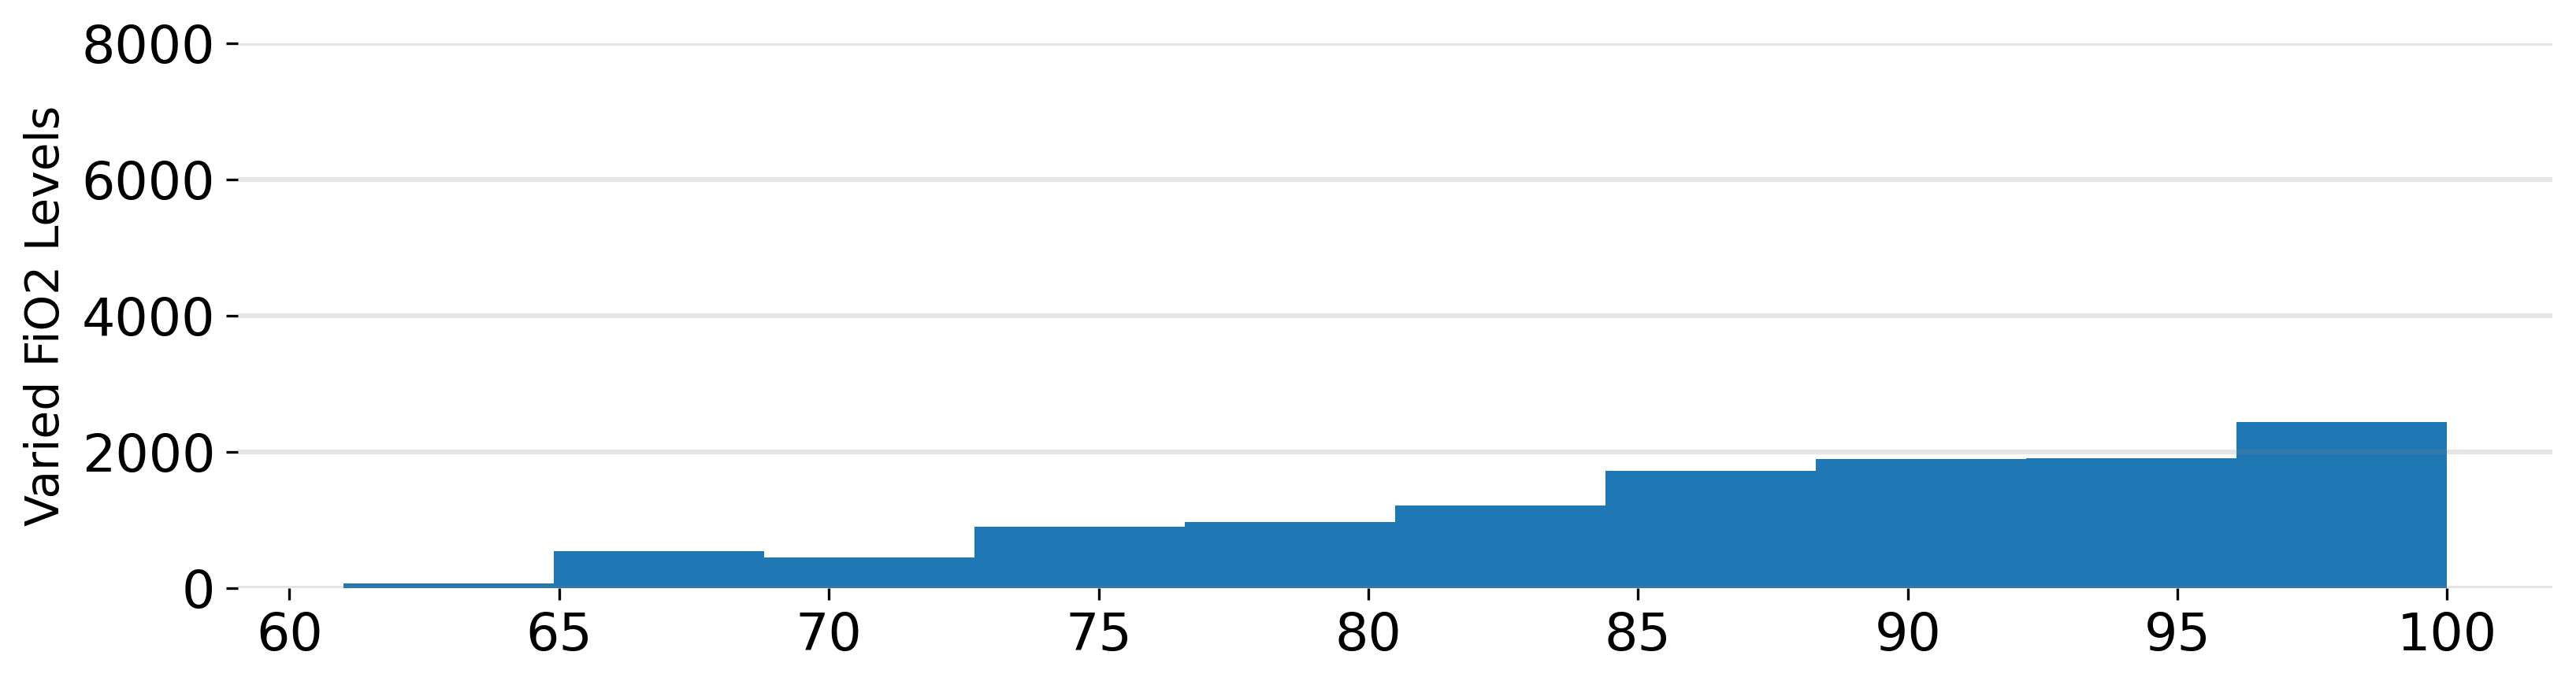

In [5]:
# Plot a historgram of the data distribution
def hist_UW():
    all_data_idx = np.ones((6,2))
    all_seq = make_temp_data(data, groundtruth, gt_ind=3, data_idx=all_data_idx)
    gtdatapoints = []
    for seq in all_seq["gt"]:
        gtdatapoints.extend(seq)
    gtdatapoints = np.array(gtdatapoints)
    print('UW: mean=%f, std=%f' % \
          (np.mean(gtdatapoints),np.std(gtdatapoints)))
    plt.figure(figsize=(11,3),dpi=300)
    plt.hist(gtdatapoints,bins=10, )
    ax = plt.gca()

    ax.set_ylim(top=8000)

    locs = ax.yaxis.get_ticklocs()
    labs = ax.yaxis.get_ticklabels()
    # print([lab.get_text() for lab in ax.yaxis.get_ticklabels()])
    new_locs = []
    new_labs = []
    for i, (loc, lab) in enumerate(list(zip(locs, labs))):
        if (i) % 2 == 0:
            # if i == 0:
            #     continue
            new_locs.append(loc)
            new_labs.append(lab)
            plt.axhline(y=loc, color="grey", alpha=0.2)

    ax.set_yticks(new_locs)
    ax.set_yticklabels(["0", "2000", "4000", "6000", "8000"], fontsize=16)

    # ax.set_xticks(ax.get_xticks(), fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_ylabel("Varied FiO2 Levels", fontsize=14)
    plt.tight_layout()

hist_UW()

In [12]:
import os
print(os.path.exists(f'{PATH}/../gt/metadata.csv'))   # True 才是对的


False


In [13]:

#location of the author folder 
PATH = '../spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed'  # 字符串

def load_metadata(metapath):
    import pandas as pd
    return pd.read_csv(metapath)

# View metadata descriptions
meta_df = load_metadata(metapath=f'{PATH}/../gt/metadata.csv')
print(meta_df.shape)


(44, 3)


In [14]:
# View metadata descriptions
def load_metadata(metapath):
    meta_df = pd.read_csv(metapath)
#     print()
    return meta_df

load_metadata(metapath=f'{PATH}//..//gt/metadata.csv')

,Label,Description,Unit
0,SpO2 1,SpO2 reading from PPG of pulse ox 1 (3900P TT+...,Percentage
1,SpO2 2,SpO2 reading from PPG of pulse ox 2 (Nellcor N...,Percentage
2,SpO2 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
3,SpO2 4,SpO2 reading from PPG of pulse ox 4 (Nellcor N...,Percentage
4,SpO2 5,SpO2 reading from PPG of pulse ox 5 (Masimo Ra...,Percentage
5,Pulse 1,Heart rate from PPG of pulse ox 1 (3900P TT+ 9...,bpm
6,Pulse 2,Heart rate from PPG of pulse ox 2 (Nellcor N-6...,bpm
7,Pulse 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
8,Pulse 4,Heart rate from PPG of pulse ox 4 (Nellcor N-6...,bpm
9,Pulse 5,Heart rate from PPG of pulse ox 5 (Masimo Radi...,bpm


In [43]:
# 覆盖原函数：自动对齐符号（corr<0 → 乘 -1），再做线性标定
import numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import mean_absolute_error

def run_loso_with_calibration(X, y, owners, model_factory,
                              epochs=180, base_lr=3e-4, wd=5e-4, bs=256, patience=25,
                              low_weight=8.0, seed=42, clamp=(70.0,100.0)):
    device = "cuda" if torch.cuda.is_available() else ("mps" if hasattr(torch.backends,'mps') and torch.backends.mps.is_available() else "cpu")
    print("device:", device)
    rng = np.random.default_rng(seed)
    X_t = torch.from_numpy(X).float(); y_t = torch.from_numpy(y).float().unsqueeze(1)
    subjects = np.unique(owners)

    y_true_all, y_pred_all, per = [], [], []
    for held in subjects:
        te = np.where(owners==held)[0]
        tr = np.where(owners!=held)[0]
        rng.shuffle(tr); n_val = max(1, int(len(tr)*0.1))
        va, tr = tr[:n_val], tr[n_val:]

        w = torch.ones(len(tr)); w[(y_t[tr].squeeze(1) < 90).cpu()] = low_weight
        sampler = WeightedRandomSampler(weights=w, num_samples=len(w), replacement=True)

        model = model_factory(X.shape[1]).to(device)
        best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        opt = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=wd)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
        loss = nn.SmoothL1Loss()
        best_mae, wait = 1e9, patience

        # 训练
        for ep in range(epochs):
            model.train()
            dl = DataLoader(TensorDataset(X_t[tr], y_t[tr]), batch_size=bs, sampler=sampler)
            for xb,yb in dl:
                xb,yb = xb.to(device), yb.to(device)
                opt.zero_grad(); l = loss(model(xb), yb.squeeze(1)); l.backward(); opt.step()
            sch.step()
            # 验证
            model.eval()
            with torch.no_grad():
                dlv = DataLoader(TensorDataset(X_t[va], y_t[va]), batch_size=bs, shuffle=False)
                pv, gv = [], []
                for xb,yb in dlv:
                    pv.append(model(xb.to(device)).cpu().numpy()); gv.append(yb.numpy())
                pv = np.concatenate(pv).squeeze(); gv = np.concatenate(gv).squeeze()
                mae_va = float(mean_absolute_error(gv, pv))
            if mae_va < best_mae - 1e-4:
                best_mae = mae_va; best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}; wait = patience
            else:
                wait -= 1
                if wait <= 0: break

        # —— 线性标定（带“符号对齐”）——
        model.load_state_dict(best_state); model.eval()
        with torch.no_grad():
            dl_cal = DataLoader(TensorDataset(torch.cat([X_t[tr], X_t[va]],0),
                                              torch.cat([y_t[tr], y_t[va]],0)),
                                batch_size=bs, shuffle=False)
            p_cal, g_cal = [], []
            for xb,yb in dl_cal:
                p_cal.append(model(xb.to(device)).cpu().numpy()); g_cal.append(yb.numpy())
        p_cal = np.concatenate(p_cal).squeeze(); g_cal = np.concatenate(g_cal).squeeze()

        # 如果负相关，就把预测整体乘以 -1 再做标定（保证单调方向正确）
        r = np.corrcoef(p_cal, g_cal)[0,1]
        flip = -1.0 if (np.isfinite(r) and r < 0) else 1.0
        p_cal = p_cal * flip

        A = np.vstack([p_cal, np.ones_like(p_cal)]).T
        a, b = np.linalg.lstsq(A, g_cal, rcond=None)[0]

        # 测试并应用相同的 flip + 标定
        with torch.no_grad():
            dlt = DataLoader(TensorDataset(X_t[te], y_t[te]), batch_size=bs, shuffle=False)
            pt = [model(xb.to(device)).cpu().numpy() for xb,_ in dlt]
        pt = np.concatenate(pt).squeeze()
        pt = flip * pt
        pt = a*pt + b
        if clamp is not None: pt = np.clip(pt, clamp[0], clamp[1])

        gt = y_t[te].numpy().squeeze()
        fold_mae = float(mean_absolute_error(gt, pt))
        print(f"[LOSO+cal] held={int(held)}  MAE={fold_mae:.3f}%  n={len(te)}  (flip={int(flip)}, a={a:.3f}, b={b:.3f})")
        y_true_all.append(gt); y_pred_all.append(pt); per.append({"subject": int(held), "mae": fold_mae, "n": int(len(te)), "a": float(a), "b": float(b), "flip": int(flip)})

    return np.concatenate(y_true_all), np.concatenate(y_pred_all), per


In [44]:
# 你上一步已经有 data / groundtruth / DEVICE_IDX
BEST_LAG = 40          # 用刚才扫出来的最优 lag
ACDC_THR = 0.015       # 如想更干净可试 0.020

# 构建样本（best-hand + 正确AC/DC归一化）
Xb, yb, ob = make_besthand_v3_with_lag_dcNorm(
    data, groundtruth,
    device_idx=DEVICE_IDX,
    lag_sec=BEST_LAG,
    acdc_thr=ACDC_THR
)

# 训练（使用你刚替换过的 run_loso_with_calibration）
y_true_b, y_pred_b, per_b = run_loso_with_calibration(
    Xb, yb, ob,
    model_factory=lambda in_ch: Shallow1DCNN(in_ch),
    epochs=180, base_lr=3e-4, wd=5e-4, bs=256, patience=25, low_weight=8.0
)
print("LOSO mean MAE =", np.mean([r['mae'] for r in per_b]))


[besthand v3 + lag=40s, dcNorm] X: (4884, 3, 90) y: (4884,)
device: mps
[LOSO+cal] held=0  MAE=9.254%  n=350  (flip=-1, a=2.241, b=276.404)
[LOSO+cal] held=1  MAE=6.473%  n=1080  (flip=-1, a=0.163, b=101.556)
[LOSO+cal] held=2  MAE=7.170%  n=986  (flip=-1, a=1.778, b=237.742)
[LOSO+cal] held=3  MAE=5.541%  n=973  (flip=-1, a=1.620, b=221.956)
[LOSO+cal] held=4  MAE=7.118%  n=815  (flip=-1, a=0.217, b=106.495)
[LOSO+cal] held=5  MAE=7.090%  n=680  (flip=-1, a=0.831, b=158.302)
LOSO mean MAE = 7.107715924580892


MAE=6.821% RMSE=8.139% R2=-0.005
MAE 70-80% = 12.469%  (n=1018)
MAE 80-90% = 3.059%  (n=1920)
MAE 90-100% = 7.093%  (n=2286)
Thr<92%  Sens=1.000  Spec=0.000  (pos=3025, neg=1859)
Thr<90%  Sens=1.000  Spec=0.000  (pos=2598, neg=2286)
Thr<88%  Sens=0.563  Spec=0.461  (pos=2112, neg=2772)


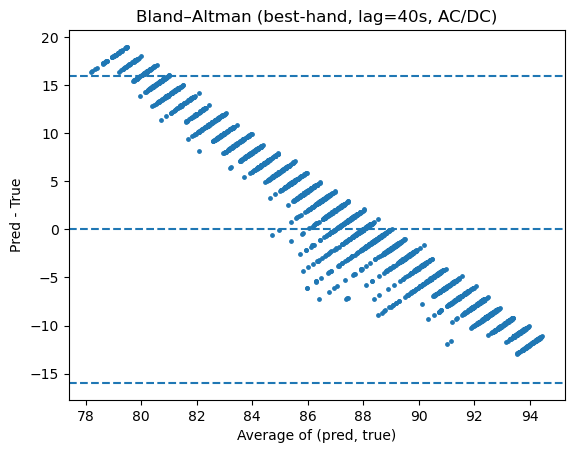

In [45]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix

yt, yp = y_true_b, y_pred_b

print(f"MAE={mean_absolute_error(yt, yp):.3f}%",
      f"RMSE={np.sqrt(np.mean((yt-yp)**2)):.3f}%",
      f"R2={r2_score(yt, yp):.3f}")
for lo, hi in [(70,80),(80,90),(90,100)]:
    m = (yt>=lo)&(yt<=hi)
    if m.any():
        print(f"MAE {lo}-{hi}% = {mean_absolute_error(yt[m], yp[m]):.3f}%  (n={m.sum()})")

def sens_spec(y_true, y_pred, thr):
    yb = (y_true < thr).astype(int); pb = (y_pred < thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(yb, pb, labels=[0,1]).ravel()
    return tp/(tp+fn+1e-8), tn/(tn+fp+1e-8), int(tp+fn), int(tn+fp)

for thr in [92.0, 90.0, 88.0]:
    s, p, pos_n, neg_n = sens_spec(yt, yp, thr)
    print(f"Thr<{thr:.0f}%  Sens={s:.3f}  Spec={p:.3f}  (pos={pos_n}, neg={neg_n})")

# Bland–Altman
diff = yp - yt; avg = 0.5*(yp + yt)
md, sd = diff.mean(), diff.std()
plt.figure(); plt.scatter(avg, diff, s=6)
plt.axhline(md, ls='--'); plt.axhline(md+1.96*sd, ls='--'); plt.axhline(md-1.96*sd, ls='--')
plt.xlabel("Average of (pred, true)"); plt.ylabel("Pred - True")
plt.title(f"Bland–Altman (best-hand, lag={BEST_LAG}s, AC/DC)"); plt.show()


In [46]:
import numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import mean_absolute_error
from sklearn.isotonic import IsotonicRegression

def _nanfill(x, fill, lo=-np.inf, hi=np.inf):
    x = np.nan_to_num(x, nan=fill, posinf=fill, neginf=fill)
    if np.isfinite(lo) or np.isfinite(hi):
        x = np.clip(x, lo, hi)
    return x

def run_loso_with_iso_cal_v2(
    X, y, owners, model_factory,
    epochs=180, base_lr=3e-4, wd=5e-4, bs=256, patience=25,
    low_weight=8.0, seed=42, clamp=(70.0, 100.0)
):
    device = "cuda" if torch.cuda.is_available() else (
        "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu"
    )
    print("device:", device)
    rng = np.random.default_rng(seed)
    X_t = torch.from_numpy(X).float()
    y_t = torch.from_numpy(y).float().unsqueeze(1)
    subjects = np.unique(owners)

    y_true_all, y_pred_all, per = [], [], []

    for held in subjects:
        te = np.where(owners == held)[0]
        tr = np.where(owners != held)[0]
        rng.shuffle(tr)
        n_val = max(1, int(len(tr) * 0.1))
        va, tr = tr[:n_val], tr[n_val:]

        # 低氧采样加权
        w = torch.ones(len(tr))
        w[(y_t[tr].squeeze(1) < 90).cpu()] = low_weight
        sampler = WeightedRandomSampler(weights=w, num_samples=len(w), replacement=True)

        # === 训练基模型 ===
        model = model_factory(X.shape[1]).to(device)
        opt  = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=wd)
        sch  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
        loss = nn.SmoothL1Loss()
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_mae, wait = float("inf"), patience

        for _ in range(epochs):
            model.train()
            dl = DataLoader(TensorDataset(X_t[tr], y_t[tr]), batch_size=bs, sampler=sampler)
            for xb, yb in dl:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad()
                l = loss(model(xb), yb.squeeze(1))
                l.backward()
                opt.step()
            sch.step()

            # 验证
            model.eval()
            with torch.no_grad():
                dlv = DataLoader(TensorDataset(X_t[va], y_t[va]), batch_size=bs, shuffle=False)
                pv, gv = [], []
                for xb, yb in dlv:
                    pv.append(model(xb.to(device)).cpu().numpy())
                    gv.append(yb.numpy())
                pv = np.concatenate(pv).squeeze()
                gv = np.concatenate(gv).squeeze()
                m = np.isfinite(pv) & np.isfinite(gv)
                mae_va = float(mean_absolute_error(gv[m], pv[m])) if m.any() else np.inf

            if mae_va < best_mae - 1e-4:
                best_mae  = mae_va
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                wait = patience
            else:
                wait -= 1
                if wait <= 0:
                    break

        # === 校准（train+val）优先 Isotonic，失败回退线性 ===
        model.load_state_dict(best_state)
        model.eval()
        with torch.no_grad():
            dl_cal = DataLoader(
                TensorDataset(torch.cat([X_t[tr], X_t[va]], 0), torch.cat([y_t[tr], y_t[va]], 0)),
                batch_size=bs, shuffle=False
            )
            p_cal, g_cal = [], []
            for xb, yb in dl_cal:
                p_cal.append(model(xb.to(device)).cpu().numpy())
                g_cal.append(yb.numpy())
        p_cal = np.concatenate(p_cal).squeeze()
        g_cal = np.concatenate(g_cal).squeeze()
        mfin = np.isfinite(p_cal) & np.isfinite(g_cal)
        p_cal, g_cal = p_cal[mfin], g_cal[mfin]

        if p_cal.size == 0:
            with torch.no_grad():
                dlt = DataLoader(TensorDataset(X_t[te], y_t[te]), batch_size=bs, shuffle=False)
                pt = np.concatenate([model(xb.to(device)).cpu().numpy() for xb, _ in dlt]).squeeze()
            pt = _nanfill(pt, fill=np.mean(clamp), lo=clamp[0], hi=clamp[1])
            gt = y_t[te].numpy().squeeze()
            fold_mae = float(mean_absolute_error(gt, pt))
            print(f"[LOSO raw] held={int(held)} MAE={fold_mae:.3f}% n={len(te)}")
            y_true_all.append(gt)
            y_pred_all.append(pt)
            per.append({"subject": int(held), "mae": fold_mae, "n": int(len(te)), "flip": 1, "fallback": True})
            continue

        # 相关性判断是否 flip
        r = np.corrcoef(p_cal, g_cal)[0, 1] if p_cal.size > 1 else 1.0
        flip = -1.0 if (np.isfinite(r) and r < 0) else 1.0
        p_cal = p_cal * flip

        # Isotonic + 类别均衡权重
        use_iso = True
        try:
            iso = IsotonicRegression(y_min=clamp[0], y_max=clamp[1], increasing=True)
            neg = (g_cal >= 90.0)          # 非低氧
            pos = ~neg                     # 低氧
            w_iso = np.ones_like(g_cal, dtype=float)
            if neg.sum() and pos.sum():
                w_iso[neg] = pos.sum() / neg.sum()
                w_iso[pos] = neg.sum() / pos.sum()
            iso.fit(p_cal, g_cal, sample_weight=w_iso)
        except Exception as e:
            print(f"[warn] isotonic failed fold {int(held)} -> fallback linear ({e})")
            use_iso = False

        # 测试集预测
        with torch.no_grad():
            dlt = DataLoader(TensorDataset(X_t[te], y_t[te]), batch_size=bs, shuffle=False)
            pt_raw = np.concatenate([model(xb.to(device)).cpu().numpy() for xb, _ in dlt]).squeeze()
        fill_cal = (np.nanmedian(p_cal) if np.isfinite(p_cal).any() else np.mean(clamp))
        pt_raw = _nanfill(pt_raw, fill_cal)

        if use_iso:
            pt = iso.predict(flip * pt_raw)
            # “≥90% 锚点”轻微上调，避免整体被压低
            cal_pred = iso.predict(p_cal)
            neg = (g_cal >= 90.0)
            if neg.sum() > 10:
                delta = float(g_cal[neg].mean() - cal_pred[neg].mean())
                if delta > 0:
                    pt = pt + 0.5 * delta
        else:
            A = np.vstack([p_cal, np.ones_like(p_cal)]).T
            a, b = np.linalg.lstsq(A, g_cal, rcond=None)[0] if p_cal.size > 1 else (1.0, 0.0)
            pt = a * (flip * pt_raw) + b

        # 评估前兜底与裁剪
        pt = _nanfill(pt, fill=(np.nanmedian(g_cal) if np.isfinite(g_cal).any() else np.mean(clamp)),
                      lo=clamp[0], hi=clamp[1])
        gt = y_t[te].numpy().squeeze()
        mg = np.isfinite(gt) & np.isfinite(pt)
        gt, pt = gt[mg], pt[mg]

        fold_mae = float(mean_absolute_error(gt, pt))
        tag = "iso" if use_iso else "lin"
        print(f"[LOSO+{tag}] held={int(held)} MAE={fold_mae:.3f}% n={len(gt)} (flip={int(flip)})")
        y_true_all.append(gt)
        y_pred_all.append(pt)
        per.append({"subject": int(held), "mae": fold_mae, "n": int(len(gt)), "flip": int(flip), "fallback": not use_iso})

    return np.concatenate(y_true_all), np.concatenate(y_pred_all), per


In [47]:
y_true_iso, y_pred_iso, per_iso = run_loso_with_iso_cal_v2(
    Xb, yb, ob, model_factory=lambda in_ch: Shallow1DCNN(in_ch),
    epochs=180, base_lr=3e-4, wd=5e-4, bs=256, patience=25, low_weight=8.0
)


device: mps
[LOSO+iso] held=0 MAE=8.418% n=350 (flip=-1)
[LOSO+iso] held=1 MAE=6.948% n=1080 (flip=-1)
[LOSO+iso] held=2 MAE=7.690% n=986 (flip=-1)
[LOSO+iso] held=3 MAE=5.208% n=973 (flip=-1)
[LOSO+iso] held=4 MAE=7.052% n=815 (flip=-1)
[LOSO+iso] held=5 MAE=8.056% n=680 (flip=-1)


LOSO mean MAE = 7.028%
MAE 70-80% = 16.812% (n=888)
MAE 80-90% = 6.401% (n=1710)
MAE 90-100% = 3.480% (n=2165)
[最佳J]  score阈值=-0.920  敏感度=0.375  特异度=0.815  (tp=974, fp=423, fn=1624, tn=1863)
[pred<90%] 敏感度=0.127  特异度=0.936  (tp=329, fp=146, fn=2269, tn=2140)


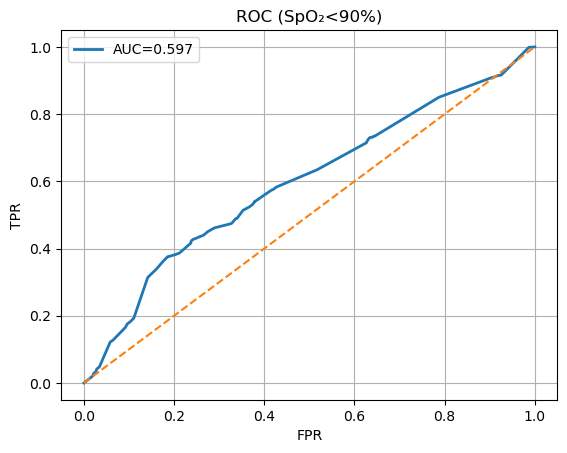

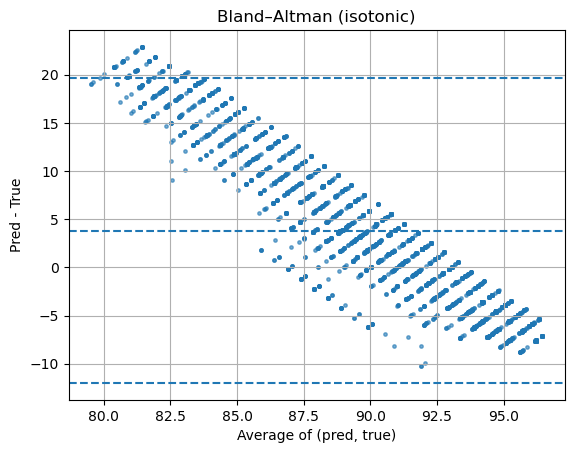

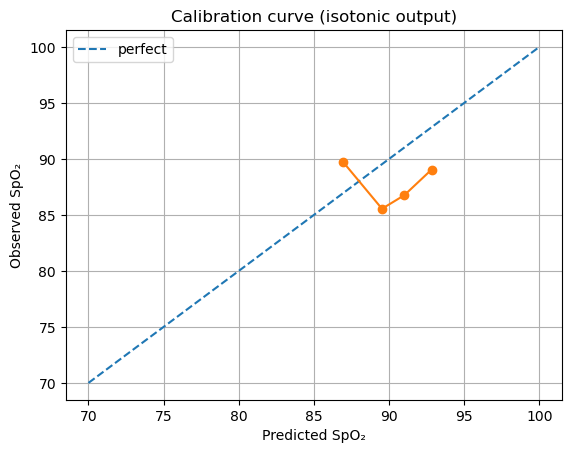

In [48]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, roc_auc_score, roc_curve, confusion_matrix

# 1) 汇总 MAE（整体 + 分区间）
print(f"LOSO mean MAE = {mean_absolute_error(y_true_iso, y_pred_iso):.3f}%")
for lo, hi in [(70,80),(80,90),(90,100)]:
    m = (y_true_iso >= lo) & (y_true_iso < hi)
    if m.any():
        print(f"MAE {lo}-{hi}% = {mean_absolute_error(y_true_iso[m], y_pred_iso[m]):.3f}% (n={m.sum()})")

# 2) ROC / AUC（以 SpO₂<90% 为“低氧”阳性）
thr = 90.0
y_pos = (y_true_iso < thr).astype(int)          # 1 = 低氧
score = thr - y_pred_iso                        # 分数越大=越可能低氧
auc = roc_auc_score(y_pos, score)
fpr, tpr, th = roc_curve(y_pos, score)
plt.figure(); plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (SpO₂<90%)"); plt.legend(); plt.grid(True)

# 选择 Youden J 最优点，并给出该点和“临床阈值90%”两套指标
j = tpr - fpr; i = np.argmax(j); thr_score = th[i]
pred_best = (score >= thr_score).astype(int)
tn, fp, fn, tp = confusion_matrix(y_pos, pred_best).ravel()
sens = tp/(tp+fn+1e-8); spec = tn/(tn+fp+1e-8)
print(f"[最佳J]  score阈值={thr_score:.3f}  敏感度={sens:.3f}  特异度={spec:.3f}  (tp={tp}, fp={fp}, fn={fn}, tn={tn})")

pred_90 = (y_pred_iso < thr).astype(int)       # 直接用 90% 作为预测阈值
tn, fp, fn, tp = confusion_matrix(y_pos, pred_90).ravel()
sens90 = tp/(tp+fn+1e-8); spec90 = tn/(tn+fp+1e-8)
print(f"[pred<90%] 敏感度={sens90:.3f}  特异度={spec90:.3f}  (tp={tp}, fp={fp}, fn={fn}, tn={tn})")

# 3) Bland–Altman
avg = (y_true_iso + y_pred_iso)/2.0
diff = y_pred_iso - y_true_iso
md, sd = diff.mean(), diff.std(ddof=1)
plt.figure(); plt.scatter(avg, diff, s=6, alpha=0.6)
for k in [0, 1.96, -1.96]:
    plt.axhline(md + k*sd, ls='--')
plt.title("Bland–Altman (isotonic)"); plt.xlabel("Average of (pred, true)"); plt.ylabel("Pred - True"); plt.grid(True)

# 4) 校准曲线（等概率分箱）
bins = np.linspace(70, 100, 16)  # 15 个 bin
idx = np.digitize(y_pred_iso, bins) - 1
px, py = [], []
for b in range(len(bins)-1):
    m = idx == b
    if m.any():
        px.append(y_pred_iso[m].mean())
        py.append(y_true_iso[m].mean())
plt.figure(); plt.plot([70,100],[70,100],'--', label="perfect")
plt.plot(px, py, marker='o'); plt.xlabel("Predicted SpO₂"); plt.ylabel("Observed SpO₂")
plt.title("Calibration curve (isotonic output)"); plt.grid(True); plt.legend()
plt.show()


In [49]:
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, roc_auc_score, roc_curve

def thr_metrics(y_true, y_pred, thr=90.0):
    """给定回归输出，计算 <thr 的敏感度/特异度，并用 -y_pred 当“低氧分数”算 AUC。"""
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    pos = (y_true < thr).astype(int)                 # 1 = 低氧
    yhat_cls = (y_pred < thr).astype(int)
    tp = int(((pos==1)&(yhat_cls==1)).sum())
    tn = int(((pos==0)&(yhat_cls==0)).sum())
    fp = int(((pos==0)&(yhat_cls==1)).sum())
    fn = int(((pos==1)&(yhat_cls==0)).sum())
    sens = tp / (tp + fn + 1e-8)
    spec = tn / (tn + fp + 1e-8)
    # 低氧越“低”越可能 ⇒ 用 -y_pred 当分数
    try:
        auc = roc_auc_score(pos, -y_pred)
    except Exception:
        auc = float("nan")
    return sens, spec, auc, dict(tp=tp, tn=tn, fp=fp, fn=fn)

def run_one_loww(Xb, yb, ob, low_w):
    y_true, y_pred, per = run_loso_with_iso_cal_v2(
        Xb, yb, ob,
        model_factory=lambda in_ch: Shallow1DCNN(in_ch),
        epochs=180, base_lr=3e-4, wd=5e-4, bs=256,
        patience=25, low_weight=low_w
    )
    mae = float(np.mean([r["mae"] for r in per]))
    sens, spec, auc, counts = thr_metrics(y_true, y_pred, thr=90.0)
    print(f"[low_weight={low_w:>4}]  LOSO mean MAE={mae:.3f}% | Sens<90={sens:.3f}  Spec≥90={spec:.3f}  AUC={auc:.3f}  N={len(y_true)}")
    return dict(low_weight=low_w, mae=mae, sens90=sens, spec90=spec, auc=auc, N=len(y_true))

# 用当前（4s窗口）的样本做权重扫描
Xb, yb, ob = make_besthand_v3_with_lag_dcNorm(
    data, groundtruth,
    device_idx=DEVICE_IDX, lag_sec=40, acdc_thr=0.02, win=120
)

scan_loww = []
for lw in [8.0, 12.0, 16.0]:
    scan_loww.append(run_one_loww(Xb, yb, ob, lw))

pd.DataFrame(scan_loww).sort_values(["mae", "spec90"], ascending=[True, False])


[besthand v3 + lag=40s, dcNorm] X: (4682, 3, 120) y: (4682,)
device: mps
[LOSO+iso] held=0 MAE=5.454% n=180 (flip=-1)
[LOSO+iso] held=1 MAE=6.757% n=1048 (flip=-1)
[LOSO+iso] held=2 MAE=7.808% n=986 (flip=-1)
[LOSO+iso] held=3 MAE=5.215% n=973 (flip=-1)
[LOSO+iso] held=4 MAE=7.574% n=815 (flip=-1)
[LOSO+iso] held=5 MAE=8.338% n=680 (flip=-1)
[low_weight= 8.0]  LOSO mean MAE=6.858% | Sens<90=0.090  Spec≥90=0.923  AUC=0.532  N=4682
device: mps
[LOSO+iso] held=0 MAE=5.439% n=180 (flip=-1)
[LOSO+iso] held=1 MAE=6.761% n=1048 (flip=-1)
[LOSO+iso] held=2 MAE=7.802% n=986 (flip=-1)
[LOSO+iso] held=3 MAE=5.367% n=973 (flip=-1)
[LOSO+iso] held=4 MAE=7.614% n=815 (flip=-1)
[LOSO+iso] held=5 MAE=8.251% n=680 (flip=1)
[low_weight=12.0]  LOSO mean MAE=6.872% | Sens<90=0.099  Spec≥90=0.930  AUC=0.519  N=4682
device: mps
[LOSO+iso] held=0 MAE=5.494% n=180 (flip=-1)
[LOSO+iso] held=1 MAE=6.745% n=1048 (flip=-1)
[LOSO+iso] held=2 MAE=7.813% n=986 (flip=-1)
[LOSO+iso] held=3 MAE=5.371% n=973 (flip=-1)
[

,low_weight,mae,sens90,spec90,auc,N
0,8.0,6.857744,0.090430,0.923285,0.532426,4682
1,12.0,6.872321,0.098946,0.930054,0.518927,4682
2,16.0,6.890816,0.089619,0.953069,0.509187,4682


[besthand v3 + lag=40s, dcNorm] X: (4672, 3, 150) y: (4672,)
device: mps
[LOSO+iso] held=0 MAE=5.256% n=175 (flip=-1)
[LOSO+iso] held=1 MAE=6.830% n=1047 (flip=-1)
[LOSO+iso] held=2 MAE=7.652% n=985 (flip=-1)
[LOSO+iso] held=3 MAE=5.224% n=972 (flip=-1)
[LOSO+iso] held=4 MAE=7.689% n=814 (flip=-1)
[LOSO+iso] held=5 MAE=8.274% n=679 (flip=-1)
LOSO mean MAE = 6.820634762446086
AUC (SpO2<90%) = 0.544


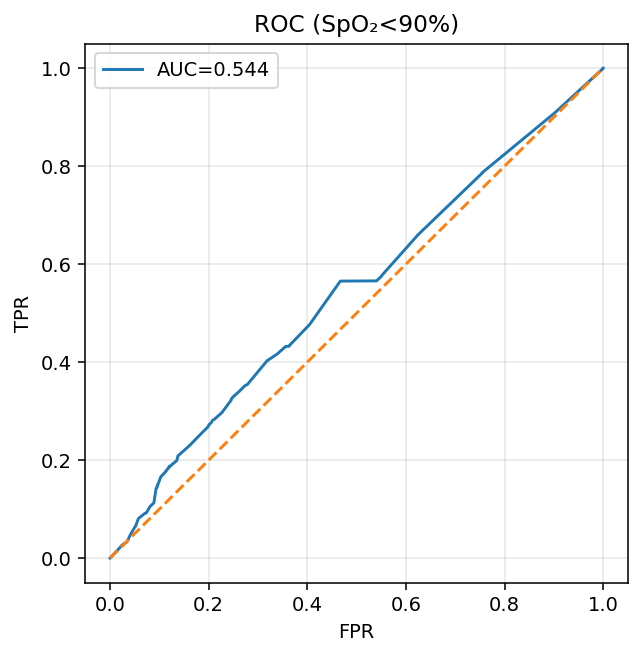

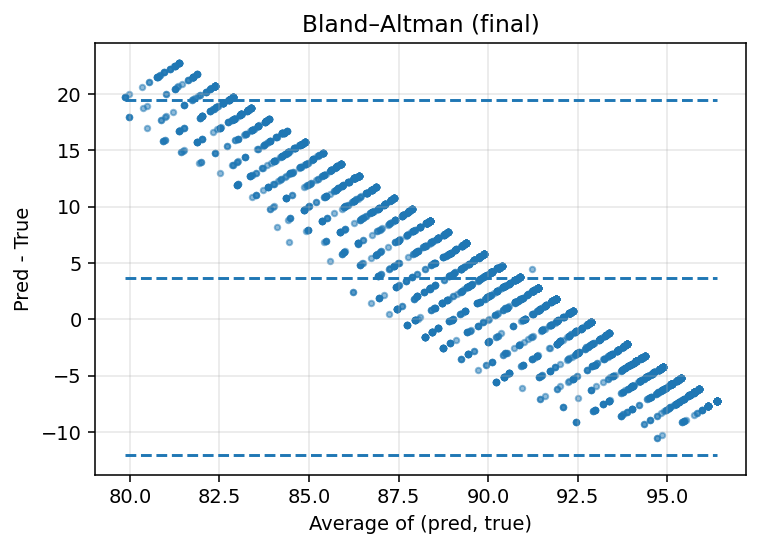

In [50]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 👉 把这两个值改成你在 A/B 中选出来的“最佳组合”
FINAL_LOWW = 12.0       # e.g. 12 或 16
FINAL_WIN  = 150        # e.g. 120(4s) 或 150(5s)

# 重新构窗
Xb, yb, ob = make_besthand_v3_with_lag_dcNorm(
    data, groundtruth,
    device_idx=DEVICE_IDX, lag_sec=40, acdc_thr=0.02, win=FINAL_WIN
)

# 训练 + 每折保序标定
y_true, y_pred, per = run_loso_with_iso_cal_v2(
    Xb, yb, ob,
    model_factory=lambda in_ch: Shallow1DCNN(in_ch),
    epochs=180, base_lr=3e-4, wd=5e-4, bs=256,
    patience=25, low_weight=FINAL_LOWW
)

# === 汇报
mae = float(np.mean([r["mae"] for r in per]))
print("LOSO mean MAE =", mae)

# --- ROC（SpO2<90%）：注意用 -y_pred 做分数 ---
pos = (y_true < 90.0).astype(int)
scores = -y_pred
auc = roc_auc_score(pos, scores)
fpr, tpr, _ = roc_curve(pos, scores)
print(f"AUC (SpO2<90%) = {auc:.3f}")

plt.figure(figsize=(5,5), dpi=140)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC (SpO₂<90%)")
plt.legend(); plt.grid(alpha=0.3); plt.show()

# --- Bland–Altman ---
avg = (y_true + y_pred)/2.0
diff = (y_pred - y_true)
m = np.isfinite(avg) & np.isfinite(diff)
avg, diff = avg[m], diff[m]
md = float(np.mean(diff)); sd = float(np.std(diff))

plt.figure(figsize=(6,4), dpi=140)
plt.scatter(avg, diff, s=8, alpha=0.5)
for z in [0, +1.96, -1.96]:
    y = md + z*sd
    plt.hlines(y, xmin=np.min(avg), xmax=np.max(avg), linestyles="--")
plt.xlabel("Average of (pred, true)")
plt.ylabel("Pred - True")
plt.title("Bland–Altman (final)")
plt.grid(alpha=0.3); plt.show()
